In [15]:
import pandas as pd
from pandasgui import show
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns
from data_parsing_functions import *

#### DICT of all courses:
with open(f"{DATA_PATH}/example_allocation_for_GT_analysis.json", "r") as infile:
    courses_with_applications = json.load(infile)

#### DICT of all Trainer Applications:
with open(f"{DATA_PATH}/trainer_applications.json", "r") as infile:
    all_trainers = json.load(infile)

ModuleNotFoundError: No module named 'pandasgui'

In [2]:
### name definition:
name = "name"
one_dayer ="One day courses"
other_courses = "Individual courses"
school_courses = "School courses"
trainee_courses= "Trainee courses"
### cluster names:
workhorse ="Workhorses"
trainee_train = "Trainee trainer"
other_trainer = "Long courses trainer"
less_worker ="Few and short courses trainer"

In [3]:
def cat_by_value(a_df, a_column, new_column):
    conditions = [(a_df[a_column] == 243.2),
                  (a_df[a_column] == 288.8),
                  (a_df[a_column] == 319.2),
                  (a_df[a_column] == 395.2),]
    values = [one_dayer, school_courses, other_courses, trainee_courses]
    a_df[new_column] = np.select(conditions, values)

In [4]:
pd.set_option('display.float_format', lambda x: '%0.2f' % x)
ratio_applications = "Ratio Applications"

df_explor = dict_allocation_to_df(courses_with_applications)
df_explor[application] = df_explor[assigned].str.len() + df_explor[wait_list].str.len()
df_explor = df_explor[[course_class, duration, number_trainers_required, pay_rate, application]]
df_explor[ratio_applications] = df_explor[application] / df_explor[number_trainers_required]

cat_by_value(df_explor, pay_rate, course_class)
import qgrid
qgrid.show_grid(df_explor)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:

num_courses = df_explor[duration].count()
sum_course_seats = int(df_explor[number_trainers_required].sum())
mean_courses_days = df_explor[duration].mean()
sum_trainer_days_requiered = int((df_explor[duration]* df_explor[number_trainers_required]).sum())
sum_applications = (df_explor[duration]*df_explor[application]).sum()
sum_course_seats
print(f"""| | |
      |--|--|
      |Number of Courses| {num_courses}|
      |Sum Course Seats| {sum_course_seats} |
      |Mean Course duration in days| {mean_courses_days} |
      |Sum of Requiered Trainer Days| {sum_trainer_days_requiered}|
      |Sum of Days Trainers Applied |{sum_applications}|""")

| | |
      |--|--|
      |Number of Courses| 48|
      |Sum Course Seats| 115 |
      |Mean Course duration in days| 3.1875 |
      |Sum of Requiered Trainer Days| 390|
      |Sum of Days Trainers Applied |542|


In [6]:
sum_course_type = df_explor.groupby(course_class).agg({pay_rate:"mean", duration: ["count", "mean"], ratio_applications: "mean"})
print(sum_course_type.to_markdown())

| Course_type        |   ('Pay Rate', 'mean') |   ('Duration', 'count') |   ('Duration', 'mean') |   ('Ratio Applications', 'mean') |
|:-------------------|-----------------------:|------------------------:|-----------------------:|---------------------------------:|
| Individual courses |                  319.2 |                       5 |                4.2     |                          2.3     |
| One day courses    |                  243.2 |                       5 |                1       |                          1.7     |
| School courses     |                  288.8 |                      34 |                3.29412 |                          1.66912 |
| Trainee courses    |                  395.2 |                       4 |                3.75    |                          1.95    |


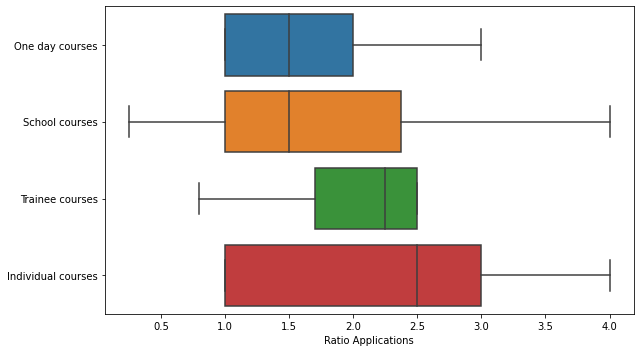

In [7]:
plt.figure(figsize=(9,5))
bar = sns.boxplot(data = df_explor, y=course_class, x=ratio_applications, orient="h")
bar.set(ylabel = None)
#plt.title("Ratio of applications by different types of courses")
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/ratio_applications_per_coursetype.svg")

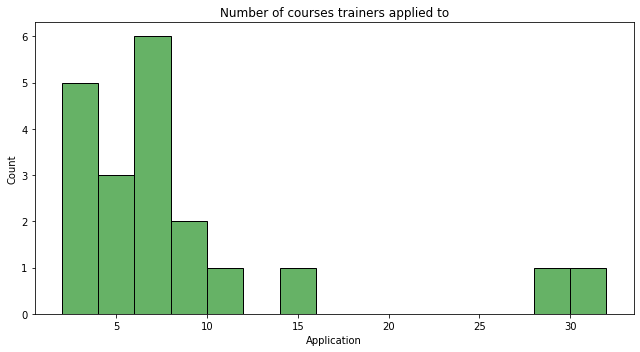

In [8]:
df_trainers_all = dict_trainer_to_df(all_trainers)
cat_by_value(df_trainers_all, pay_rate, course_class)
df_trainers = df_trainers_all.groupby("name").agg({duration: "mean", application: "count"})

plt.figure(figsize=(9,5))
#sns.histplot(data= df_trainers, x = duration, bins=15, label="Number of Days")
sns.histplot(data= df_trainers, x = application, bins=15, color="green", alpha=0.6, label="Number of Courses")
plt.title("Number of courses trainers applied to")
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/histplot_application_days.svg")

In [9]:
display(df_trainers)

,Duration,Application
name,,
Amelie,2.67,6
Chiara,3.50,14
Henriette,3.57,7
Justus,3.33,3
Kurt,3.00,4
Lara,3.75,4
Lena,2.33,3
Manu,3.27,11
Marie,2.00,3


In [10]:
df_trainers_cross = pd.crosstab(df_trainers_all["name"], df_trainers_all[course_class])
df_trainers_cross = df_trainers_cross.join(df_trainers[duration])

In [11]:
df_cross_uni = stand_df(df_trainers_cross, "None")

Standardizing the dataframe []


,withinss,num_clusters,delta,delta_percent
0,95.00,1,NaN,NaN
1,70.63,2,-24.37,-25.65
2,49.20,3,-21.43,-30.34
3,37.16,4,-12.04,-24.47
4,30.25,5,-6.91,-18.60
5,24.40,6,-5.85,-19.35
6,18.52,7,-5.88,-24.08
7,15.14,8,-3.38,-18.27
8,12.06,9,-3.08,-20.32


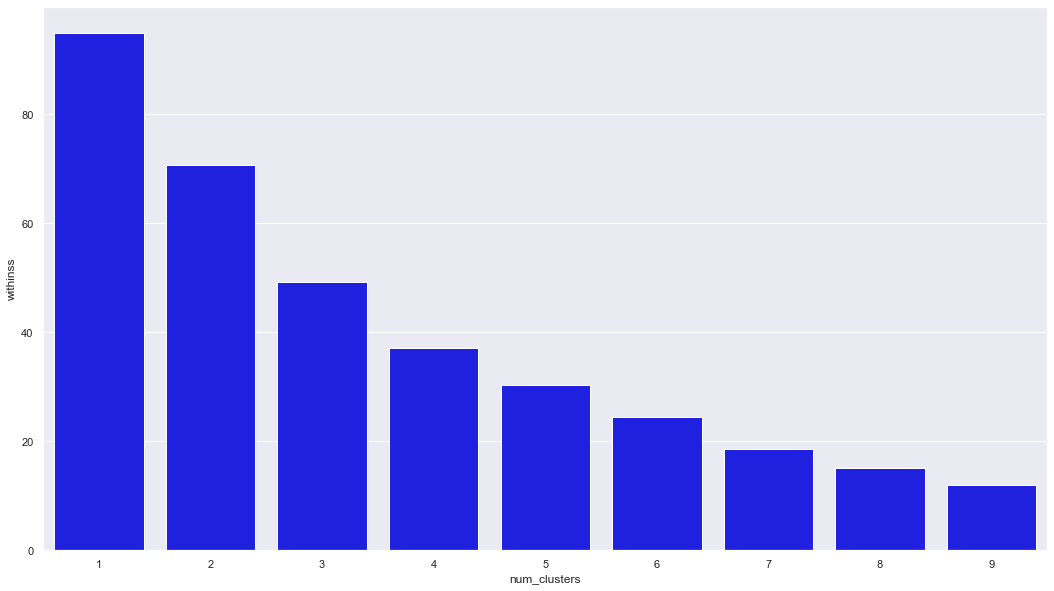

In [12]:
from pca import pca 
from sklearn.cluster import KMeans

# K- Means clustering -> Selecting number of clusters:
def selecting_number_of_clusters (a_df, exclude_column_name = None, max_cluster=10, random_state=50):
    df = a_df.copy()
    if exclude_column_name != None:
        df = df.loc[:, df.columns!=exclude_column_name]
    
    num_clusters_lst = [x for x in range(1,max_cluster)]
    names = [x for x in range(1,max_cluster)]
    withinss_lst = []
    withinss_lst_inertia = []
    for i in num_clusters_lst:
        km_x = KMeans(n_clusters=i, init="random", n_init=50, random_state=random_state).fit(df)
        withinss_lst.append(km_x)
        withinss_lst_inertia.append(km_x.inertia_)


    wss = pd.DataFrame({"withinss": withinss_lst_inertia, "num_clusters": names})
    wss["delta"] = wss["withinss"].diff(periods=1)
    wss["delta_percent"] = wss["withinss"].pct_change()*100
    sns.set(rc={"figure.figsize":(18, 10)})
    ax = sns.barplot(x="num_clusters", y="withinss", data=wss, color="blue")
    plt.show

    display(wss)
    return withinss_lst

k_means_lst = selecting_number_of_clusters(df_cross_uni)


,Individual courses,One day courses,School courses,Trainee courses,Duration,Clusters
name,,,,,,
Amelie,1.21,1.38,-0.87,1.19,-0.99,2
Chiara,0.11,-0.52,0.81,0.20,0.33,2
Henriette,1.21,-0.52,-0.17,-0.80,0.45,2
Justus,-0.99,-0.52,-0.45,-0.80,0.07,1
Kurt,-0.99,-0.52,-0.31,-0.80,-0.46,1
Lara,0.11,-0.52,-0.59,0.20,0.73,2
Lena,-0.99,-0.52,-0.45,-0.80,-1.52,1
Manu,-0.99,0.43,0.39,0.20,-0.03,1
Marie,-0.99,1.38,-0.73,-0.80,-2.05,1


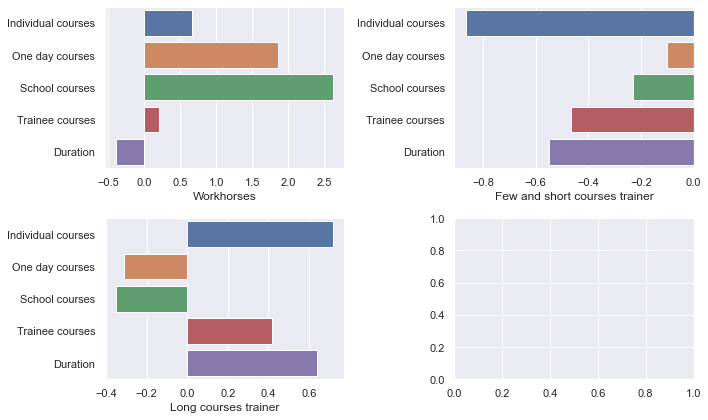

In [13]:

def dispaly_k_means_infomartion (a_df, num_km, exclude_columne = None):
    import math
    if exclude_columne == None:
        index_lst = ["Clusters"]
        a = 0
    else:
        index_lst = [exclude_columne, "Clusters"]
        a = 1
    
    df = a_df.copy()
    df["Clusters"] = num_km.labels_
    centroids = df.groupby(["Clusters"]).mean()
    centroids = centroids.rename(index={0: less_worker, 1: other_trainer, 2: workhorse, 3:"Less Worker"}) 

    display(centroids)
    
    
    df.set_index(index_lst, inplace=True)
    PCA = pca(n_components=df.shape[0], normalize=False)
    pca_results = PCA.fit_transform(df)
    pc = pca_results["PC"].iloc[:,0:2].copy()
    display(pca_results["loadings"])
    pc["Clusters"] = num_km.labels_
   
    
    n_clusters = num_km.get_params()["n_clusters"]     
    fig, ax = plt.subplots(1, figsize=(9,5))
    colors = plt.cm.get_cmap('tab10', pc.loc[:, 'Clusters'].nunique())
    text_offset = 0.1
   
    for cluster in pc['Clusters'].unique():
        df_cluster = pc[pc['Clusters'] == cluster]
        color = colors(cluster)

        plt.scatter(df_cluster['PC1'], df_cluster['PC2'], label=cluster, color=color) 
        # for index, row in df_cluster.iterrows():
        #     txt = plt.text(row['PC1']+text_offset, row['PC2'], index, size='medium', color=color)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title = "Clusters")
    plt.show()
    return 


def dispaly_k_means_centroids_bar_plot (a_df, num_km, exclude_columne = None, a_num_cols=2):
    import math
    if exclude_columne == None:
        index_lst = ["Clusters"]
    else:
        index_lst = [exclude_columne, "Clusters"]
    
    df = a_df.copy()
    df["Clusters"] = num_km.labels_
    display(df)
    df["Clusters"] = df["Clusters"].replace([0, 1,2], [workhorse, less_worker, other_trainer])

    centroids = df.groupby(["Clusters"]).mean()
    centroids = centroids.rename(index={0: workhorse, 1: trainee_train, 2: other_trainer, 3:less_worker})   
    num_plts = len(centroids)
    fig, axs = plt.subplots(math.ceil(num_plts/a_num_cols), a_num_cols, figsize=(10, 2*num_plts));
    flat_axs = axs.flatten();
    #fig.suptitle("Distribution of the number of courses trainers have applied per course type")
    for counter in range(len(centroids)):
        bar = sns.barplot(x=centroids.iloc[counter-1], ax=flat_axs[counter], y=centroids.columns)
        bar.set(ylabel = None)
    #plt.yticks(rotation=60)
    plt.tight_layout()
    plt.savefig(f"{RESULTS_PATH_abs}/barplot_clusters_trainers.svg")

    return df
    
#dispaly_k_means_infomartion(df_cross_uni, k_means_lst[2])
cluster_trainer_df = dispaly_k_means_centroids_bar_plot(df_cross_uni, k_means_lst[2])

In [14]:
comb_trainer_clusters_df = pd.concat([df_trainers_cross, cluster_trainer_df["Clusters"]], axis=1)
comb_trainer_clusters_df.reset_index(inplace=True)

group_trainer = comb_trainer_clusters_df.groupby("Clusters").agg({name: "count", one_dayer: "mean", other_courses: "mean",school_courses: "mean", trainee_courses:"mean", duration:"mean"})
group_trainer["Total Number of Course Applications"] = group_trainer[one_dayer] + group_trainer[other_courses] + group_trainer[school_courses] + group_trainer[trainee_courses]
display(group_trainer)

,name,One day courses,Individual courses,School courses,Trainee courses,Duration,Total Number of Course Applications
Clusters,,,,,,,
Few and short courses trainer,9,0.44,0.11,4.56,0.33,2.94,5.44
Long courses trainer,9,0.22,1.56,3.67,1.22,3.69,6.67
Workhorses,2,2.50,1.50,25.00,1.00,3.04,30.00
